# RC section mesh

In [1]:
import numpy as np
from opstool.preprocessing.section import SecMesh, Rebars, add_polygon, add_circle, offset

## Generate geometric objects

In [2]:
# the points of the outer contour line, only the turning point of the line is needed, counterclockwise or clockwise.
outlines = [[0.5, 0], [7.5, 0], [8, 0.5], [8, 4.5],
            [7.5, 5], [0.5, 5], [0, 4.5], [0, 0.5]]
# cover thick
cover_d = 0.08
# Offset to get the inner boundary of the cover layer
coverlines = offset(outlines, d=cover_d)

# Generate polygonal geometry object for cover layer
cover = add_polygon(outlines, holes=[coverlines])

# Creating core with voids
holelines1 = [[1, 1], [3.5, 1], [3.5, 4], [1, 4]]
holelines2 = [[4.5, 1], [7, 1], [7, 4], [4.5, 4]]
core = add_polygon(coverlines, holes=[holelines1, holelines2])

## Generate mesh

In [3]:
sec = SecMesh(sec_name="My Fiber Section")
# Grouping, the dict key is the group name, which can be arbitrary.
sec.assign_group(dict(cover=cover, core=core))
# Specify the grid size
sec.assign_mesh_size(dict(cover=0.2, core=0.4))
sec.assign_group_color(dict(cover="gray", core="green"))
# Specify the material tag in the opensees, the material needs to be defined by you beforehand.
sec.assign_ops_matTag(dict(cover=1, core=2))
# mesh!
sec.mesh()

## add rebars

In [4]:
# Instantiating the rebar class
rebars = Rebars()

rebar_d_outer = 0.032   # dia of rebar
rebar_d_inner = 0.02
# Offset to obtain the rebars arranged along the contour line, Inward offset is positive
rebar_lines1 = offset(outlines, d=cover_d + rebar_d_outer / 2)
# add the rebar line, gap is the spacing of the rebars, matTag is the opensees material tag predefined.
rebars.add_rebar_line(
    points=rebar_lines1, dia=rebar_d_outer, gap=0.15, color="red", matTag=3
)
# Offset to obtain the rebars arranged along the holes
rebar_lines2 = offset(holelines1, d=-(cover_d + rebar_d_inner / 2))
rebars.add_rebar_line(
    points=rebar_lines2, dia=rebar_d_inner, gap=0.2, color="black", matTag=3
)
rebar_lines3 = offset(holelines2, d=-(cover_d + rebar_d_inner / 2))
rebars.add_rebar_line(
    points=rebar_lines3, dia=rebar_d_inner, gap=0.2, color="black", matTag=3
)

In [5]:
# add to the sec
sec.add_rebars(rebars)

## Get the section properties

In [6]:
sec_props = sec.get_sec_props(display_results=False, plot_centroids=False)
for key, value in sec_props.items():
    print(f"{key}: {value}")

A: 24.500000000000004
Asy: 13.962700538339337
Asz: 12.118680669217847
centroid: (3.999999999999998, 2.499999999999999)
Iy: 69.35416666666686
Iz: 152.2291666666673
Iyz: 5.684341886080802e-14
J: 158.25255667724676
phi: -89.99999999999997
rho_rebar: 0.006746858737195126
E_eff: 1.0
G_eff: 0.5
Nu_eff: 0.0


## centering or rotate the section

In [7]:
sec.centring()
#sec.rotate(90)

## View the section mesh

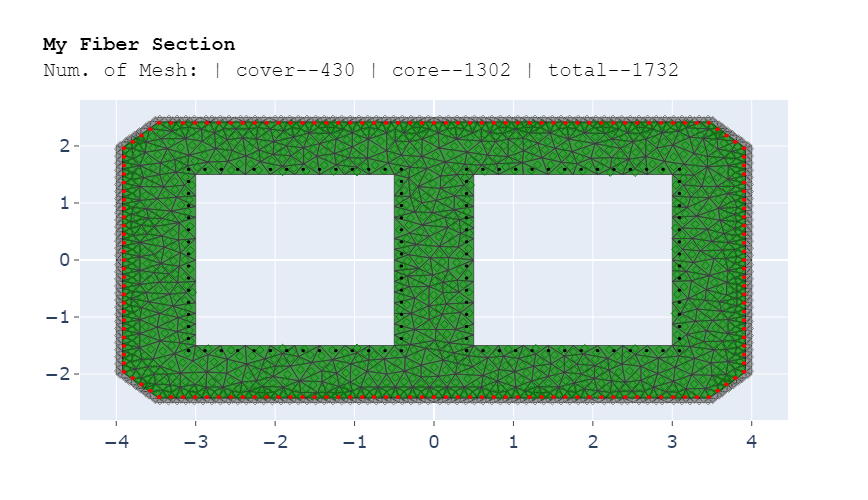

In [8]:
sec.view(fill=True, engine='plotly', save_html=None, on_notebook=True)

and engine='matplotlib'

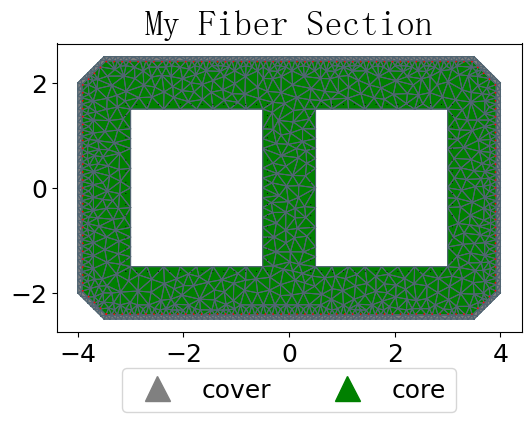

In [9]:
sec.view(fill=True, engine='matplotlib')

## Generate py or tcl file

In [10]:
G = 10000   # Shear modulus
sec.to_file("mysec.py", secTag=1, GJ=G * sec_props['J'])
# sec.to_file("mysec.tcl", secTag=1, GJ=G * sec_props['J'])

## Generate openseespy cmds implicitly

It's done, you don't need to do anything more.

# Composite Section Mesh

In [11]:
import numpy as np
from opstool.preprocessing.section import SecMesh, add_material, add_polygon, add_circle, offset, Rebars

Specify the characteristics of each material

In [12]:
# case 9
Ec = 3.45E7
Es = 2.0E8
Nus = 0.3
Nuc = 0.2
steel_mat = add_material(name='steel', elastic_modulus=Es, poissons_ratio=Nus)
conc_mat = add_material(name='conc', elastic_modulus=Ec, poissons_ratio=Nuc)

Use predefined materials when generating geometric objects

In [13]:
outlines = [[0, 0], [2, 0], [2, 2], [0, 2]]
coverlines = offset(outlines, d=0.05)
cover = add_polygon(outlines, holes=[coverlines], material=conc_mat)
bonelines = [[0.5, 0.5], [1.5, 0.5], [1.5, 0.7], [1.1, 0.7], [1.1, 1.3], [1.5, 1.3], [1.5, 1.5],
             [0.5, 1.5], [0.5, 1.3], [0.9, 1.3], [0.9, 0.7], [0.5, 0.7], [0.5, 0.5]]
core = add_polygon(coverlines, holes=[bonelines], material=conc_mat)
bone = add_polygon(bonelines, material=steel_mat)

mesh

In [14]:
sec = SecMesh()
sec.assign_group(dict(cover=cover, core=core, bone=bone))
sec.assign_mesh_size(dict(cover=0.02, core=0.05, bone=0.02))
sec.assign_group_color(dict(cover="gray", core="blue", bone='yellow'))
sec.assign_ops_matTag(dict(cover=1, core=2, bone=4))
sec.mesh()

add rebars

In [15]:
# add rebars
rebars = Rebars()
rebar_lines1 = offset(outlines, d=0.05 + 0.032 / 2)
rebars.add_rebar_line(
    points=rebar_lines1, dia=0.032, gap=0.1, color="red", matTag=3
)
# add to the sec
sec.add_rebars(rebars)

In [16]:
sec_props = sec.get_sec_props(Eref=Es, display_results=False)

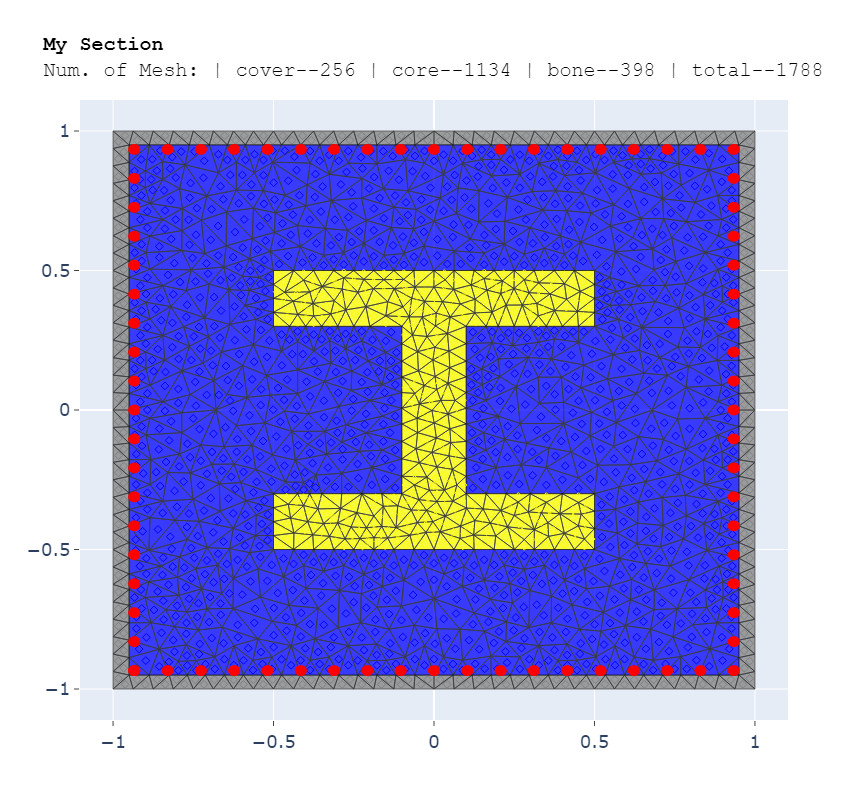

In [17]:
sec.centring()
sec.view(fill=True, engine='plotly', save_html=None, on_notebook=True)

output the file

In [18]:
Gs = Es / 2 / (1 + Nus)
sec.to_file("mysec.py", secTag=1, GJ=Gs * sec_props['J'])